In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from pandas.api.types import is_object_dtype
from sklearn.kernel_ridge import KernelRidge

In [3]:
def durbin_watson(res, y):
    '''Calculates the Durbin Watson statistic. Its sorted by age to see if there is autocorrelation'''
    sort_index = np.argsort(y,axis=0)
    res_ = res.copy()
    res_ = res_.iloc[sort_index]
    res_sum_ = res_ - np.roll(res_, 1)
    res_sum_top = np.sum(res_sum_[1:]**2)
    res_sum_bot = np.sum(res**2)
    return res_sum_top / res_sum_bot

In [4]:
csv_data = pd.read_csv('immo_dev_data.csv') # Hallo?

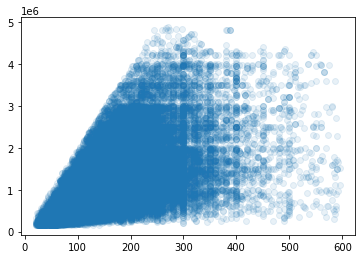

In [ ]:
X = csv_data['AreaLiving'].to_numpy().reshape(-1, 1)
y = csv_data['PurchasePrice']
plt.scatter(X, y, alpha = 0.1)
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)
reg = sklearn.linear_model.LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.39056259286920514

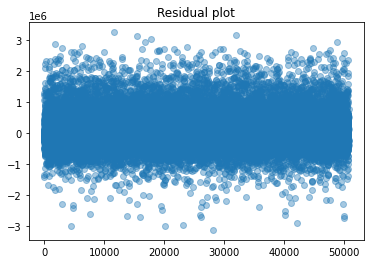

In [ ]:
y_hat = reg.predict(X_test)
residuen = y_test - y_hat
plt.scatter(np.arange(len(residuen)), np.array(residuen), alpha = 0.4)
plt.title("Residual plot")
plt.show()

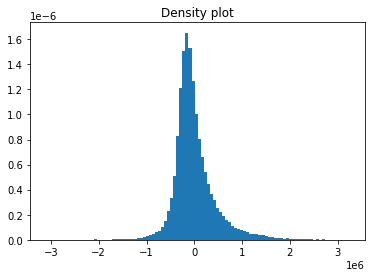

In [ ]:
plt.hist(residuen, bins = 100, density = True, histtype = 'stepfilled')
plt.title("Density plot")
plt.show()

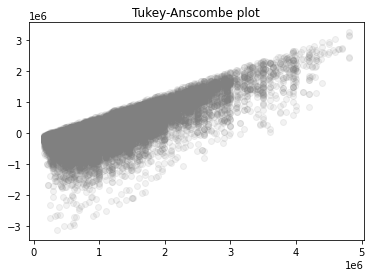

In [ ]:
plt.scatter(y_test, np.array(residuen), alpha = 0.1, color = 'grey')
plt.title("Tukey-Anscombe plot")
plt.show()

In [ ]:
 durbin_watson(residuen, y_test)

0.7389750755732111

Man kann anhand Durbin Watson sehen, dass es eine positive Autokorrelation hat, das also die Varianz zunimmt mit "Area Living". 
Dies sehen wir auch im Tukey-Anscombe Plot. Wir können mit einem Linearen Modell also nicht die Varianz komplett erklären. 

In [5]:
class preprocessor:
    def __init__(self, df, y_var, cols_to_drop = []):
        self.y = df[y_var].copy()
        cols_to_drop.append(y_var)
        print('Columns dropped to create X: ', cols_to_drop)
        if len(cols_to_drop) == 1:
            self.X = df.drop(columns = [y_var])
        else:
            self.X = df.drop(columns = cols_to_drop)
        self.enc = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
        self.scaler = sklearn.preprocessing.StandardScaler(with_std=False)
    

    def __fillna(self, _df):
        df = _df.copy()
        for col in df:
            #get dtype for column
            dt = df[col].dtype
            #check if it is a number
            if is_object_dtype(dt):
                df[col] = df[col].fillna("No Entry")
            else:
                df[col] = df[col].fillna(-1)
        return df


    def __fit_df(self):
        """
        This function fits (one hot encoding) the categorical columns if they are of type object and
        function fits (standardscaler) the numerical columns if they are of numbers (based on select_dtypes).
        Takes:
        - _df: pandas.DataFrame
        - enc: sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore') object

        returns:
        - encoded df as numpy.array
        """
        # Fit for onehot-encoder
        df_obj = self.X_train_df.select_dtypes(include = [object])
        self.enc.fit(df_obj)
        
        # Fit for standard scaler:
        df_num = self.X_train_df.select_dtypes(include = 'number')
        self.std = df_num.std(axis=0).fillna(1)
        self.mean = df_num.mean(axis=0).fillna(0)

    def __encode_transform_df(self, _df):
        """
        This function transforms the new df with the fitted encoder (one hot encoding).

        Takes:
        - _df: pandas.DataFrame
        - enc: sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore') object

        returns:
        - transformed df as numpy.array
        """

        df = _df.copy()
        df_obj = df.select_dtypes(include = [object])
        df.drop(columns = df_obj.columns, inplace=True)
        return np.concatenate((df.to_numpy(), self.enc.transform(df_obj).toarray()), axis = 1)
        

    def __standardise_df(self, _df):
        """
        This function transforms the new df with the fitted encoder (one hot encoding).

        Takes:
        - _df: pandas.DataFrame
        - enc: sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore') object

        returns:
        - transformed df as numpy.array
        """
        df = _df.copy()
        df_num = df.select_dtypes(include = 'number')
        df.drop(columns = df_num.columns, inplace=True)
        df_num = ((df_num - self.mean) / (self.std)).copy()
        df = df.join(df_num)
        return df


    def split_X_y(self, test_frac = 0.2):
        self.X_test_df = self.X.sample(frac = test_frac)
        self.X_train_df = self.X.drop(index = self.X_test_df.index, axis = 0)
        self.y_train_df = self.y.iloc[self.X_train_df.index]
        self.y_test_df = self.y.iloc[self.X_test_df.index]

    def encode_sample(self, _sample):
        sample = _sample.copy()
        sample = self.__fillna(sample)
        sample = self.__standardise_df(sample)
        sample = self.__encode_transform_df(sample)
        return sample

    def preprocess(self):
        self.split_X_y()
        self.__fit_df()
        self.X_train_df = self.__fillna(self.X_train_df).copy()
        self.X_train_df = self.__standardise_df(self.X_train_df).copy()
        self.X_train = self.__encode_transform_df(self.X_train_df).copy()
        self.X_test = self.encode_sample(self.X_test_df)

In [6]:
prepro = preprocessor(csv_data.iloc[:5000], y_var='PurchasePrice', cols_to_drop=['StreetAndNr', 'Id'])
prepro.preprocess()

Columns dropped to create X:  ['StreetAndNr', 'Id', 'PurchasePrice']


In [9]:
clf = KernelRidge(alpha=1.0)
clf.fit(prepro.X_train, prepro.y_train_df)
clf.score(prepro.X_test, prepro.y_test_df)

0.7014114993824129

In [ ]:
## Parameter for Gridsearch with Crossvalidation
parameters = {'kernel':('rbf', 'poly', 'laplacian'), 
                'alpha':np.arange(0, 1.01, 0.2),
}
model = KernelRidge()
clf = GridSearchCV(model, parameters, verbose=1)
clf.fit(prepro.X_train, prepro.y_train_df)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution inste

KeyboardInterrupt: 

preprocessor